<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesor: Tomás Fontecilla </em><br>

</div>

### **TAREA: Redes Convolucionales**

*02 de Diciembre de 2024*

**Nombre Estudiante(s)**: Cristian Tobar

### **1. Introducción**

En esta tarea, aplicaremos redes neuronales convolucionales (CNN) utilizando [la base de datos "Chihuahuas vs Muffin" de Kaggle][BD]. Además, compararemos los resultados obtenidos con un modelo de perceptrón multicapa (MLP) para determinar cuál de los dos modelos ofrece una mejor precisión en la clasificación de imágenes.

[BD]: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification

### **2. Objetivo**

El objetivo es analizar y evaluar el rendimiento de ambos enfoques en términos de precisión y eficacia, proporcionando una visión clara sobre sus fortalezas y debilidades en la tarea de clasificación.

### **3. Metodología**

- Lectura y pre-procesamiento del Conjunto de Datos.
- Visualizando Imágenes
-	Perceptrón Multicapa para Clasificación de Imágenes
-	Redes Neuronales Convolucionales
-	Conclusión 


#### **Librerías requeridas**

In [20]:
import keras
import zipfile
import io
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
from keras.datasets import mnist # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from tensorflow.keras.optimizers import SGD

#### **Lectura y pre-procesamiento del Conjunto de Datos**

La lectura de los sets de entrenamiento y validacion.

Antes de entrenar el modelo debemos:
- Normalizar los valores de los píxiles de los datos en el mismo rango (0,1).
- División del conjunto de datos (Prueba y entrenamiento). 


In [4]:
# Ruta del archivo ZIP 
zip_path = '../CNN/data/datos.zip' 
extract_path = '../CNN/data'
# Abre el archivo Zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref: 
    zip_ref.extractall(extract_path)    
    
# Rutas de los datos
train_dir = '../CNN/data/train'
test_dir = '../CNN/data/test'

Cargar el conjunto de datos de entrenamiento y prueba. 

- **IMAGEN_SIZE**: Se implementa un tamaño de 128x128 píxeles, que funciona bien con muchas arquitecturas de modelos.
- **BATCH_SIZE**: Define el número de muestras que se procesan antes de que el modelo actualice sus pesos, se utilizará un número de 64.

- **ImageDataGenerator**: Para escalar los píxeles de las imágenes y aplicar aumentos como volteos verticales y horizontales. Esto ayudará a mejorar la generalización de tu modelo al introducir variaciones en las imágenes de entrenamiento.

In [32]:
import os
BATCH_SIZE = 64 
IMAGEN_SIZE = (128, 128) 


def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verificar que el archivo es una imagen válida
            except (UnidentifiedImageError, IOError):
                os.remove(file_path)  # Eliminar el archivo no válido

# Verificar imágenes en los directorios de entrenamiento y prueba
verify_images(train_dir)
verify_images(test_dir)


# Crear un generador de datos
data_generator = ImageDataGenerator(rescale=1./255, # Normalizar las imágenes
                                    rotation_range=20,  # Rotar las imágenes aleatoriamente dentro de un rango de 20 grados
                                    zoom_range=0.2,  # Aplicar zoom aleatorio a las imágenes
                                    fill_mode='nearest',  # Utilizar 'nearest' para completar píxeles faltantes tras transformaciones
                                    channel_shift_range=0.1,  # Desplazamiento aleatorio de los canales de color
                                    vertical_flip=True, 
                                    horizontal_flip=True)

# Cargar el conjunto de datos de entrenamiento
train_dataset = data_generator.flow_from_directory(
    train_dir,
    target_size=IMAGEN_SIZE,  
    batch_size=BATCH_SIZE,
    class_mode='binary' #Clasificación binaria
)

# Cargar el conjunto de datos de prueba
test_dataset = data_generator.flow_from_directory(
    test_dir,
    target_size=IMAGEN_SIZE,  
    batch_size=BATCH_SIZE,
    class_mode='binary' 
)


Found 4733 images belonging to 3 classes.
Found 1184 images belonging to 3 classes.


### **Visualizando Imágenes**
Una excelente manera de ganar un entendimiento de los datos con los que estamos lidiando es mirando un par de ejemplos.

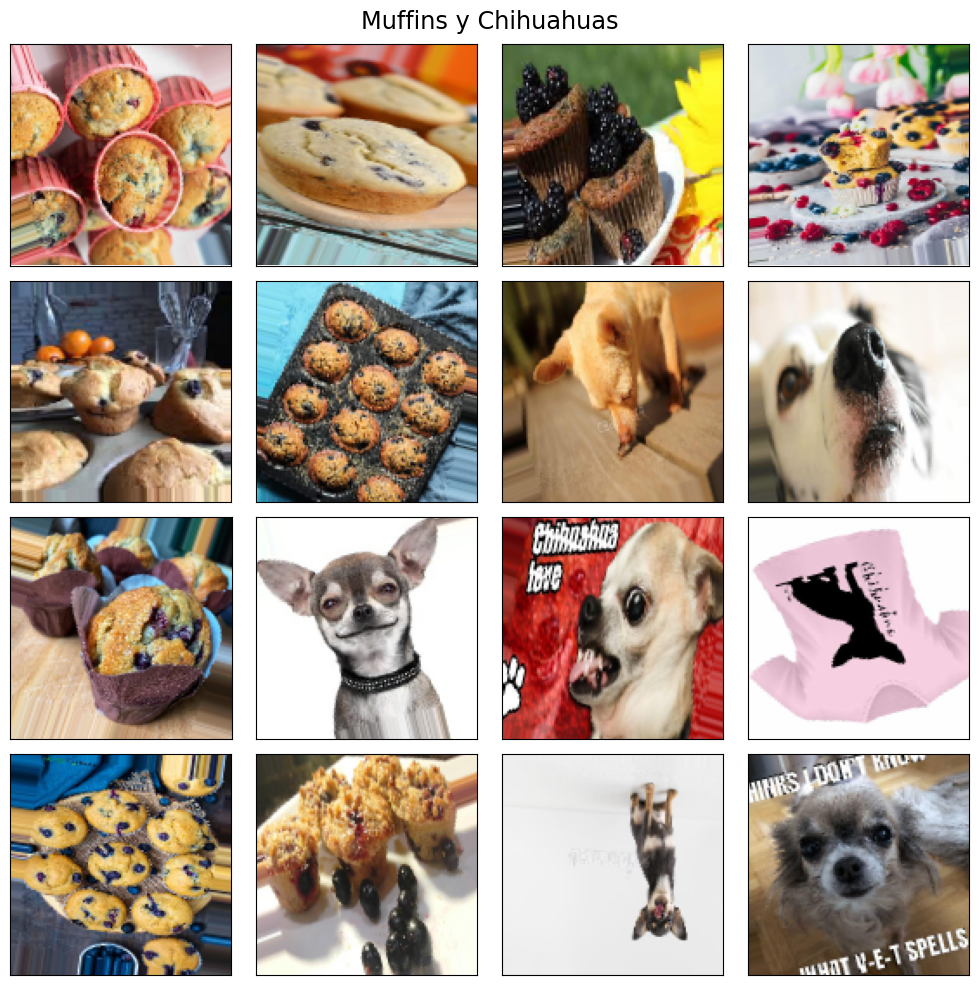

In [33]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Muffins y Chihuahuas', fontsize='xx-large')

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)   
    img = train_dataset[0][0][i]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

En el gráfico de arriba observamos varias instancias de los datos, la cual contiene 16 imágenes más pequeñas dispuestas en una cuadrícula de 4x4. Entre los ejemplos en la muestra, podemos ver muffins y chihuahuas. Algunas imágenes muestran muffins en varias situaciones, como en platos, en bandejas para hornear o con arándanos. Otras imágenes muestran chihuahuas en diferentes poses y escenarios, incluyendo primeros planos, ilustraciones y fotos con otros animales. El collage yuxtapone creativamente los dos sujetos, haciéndolo visualmente interesante y lúdico.

### **Imagen Detallada**
Solo para entender mejor lo que la computadora realmente ve, miremos una de éstas imágenes en su forma real: Una matriz.

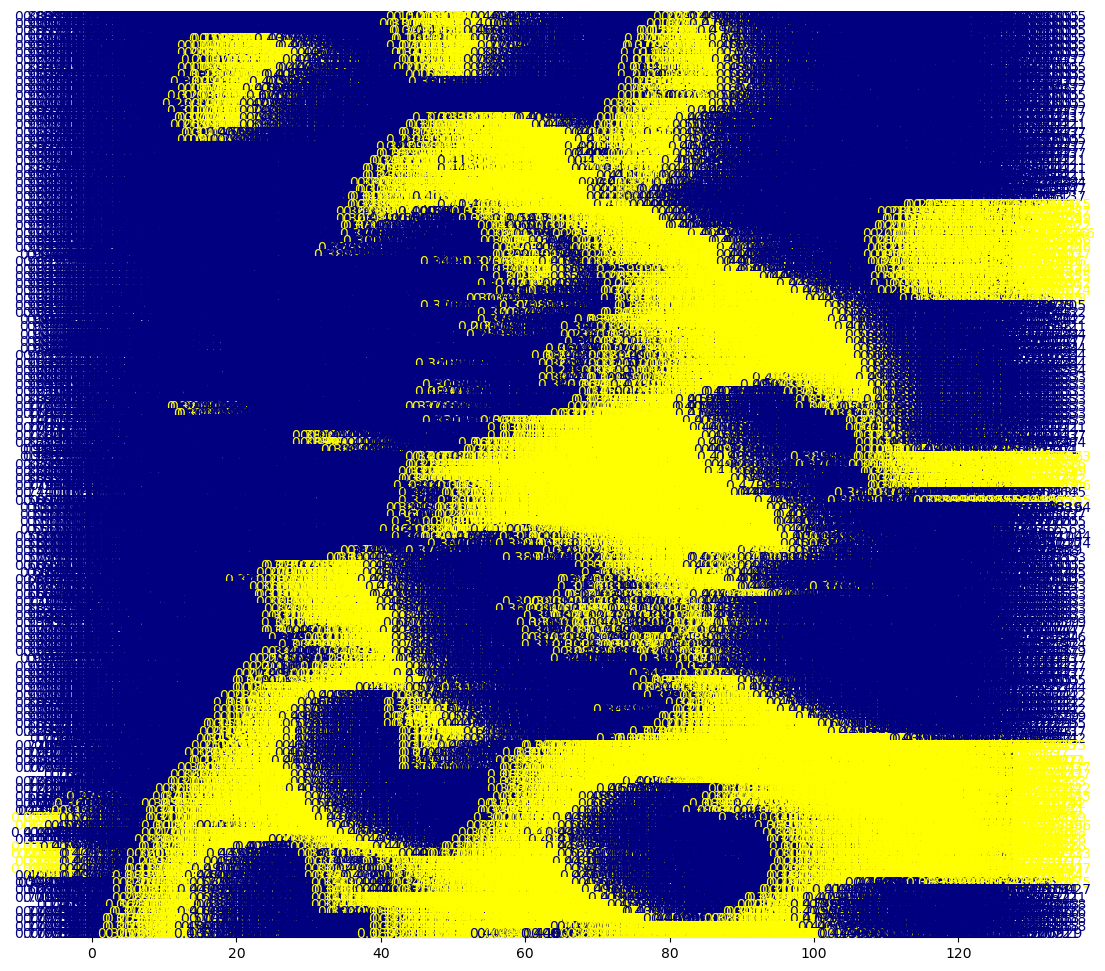

In [34]:
def visualize_input(image, ax):
    ax.imshow(image, cmap='gray')
    width, height = image.shape
    threshold = image.max() / 2.5 # cálculo del umbral, util para segmetar o resaltar partes específicas de una img.
    
    # REcorre cada píxel de la imagen y anota el valor del píxel en el gráfico
    for x in range(width):
        for y in range(height):
            pixel_value = image[x][y] #Obtiene el valor del píxel en la posición
            ax.annotate(f'{round(pixel_value, 2)}',  #Agrega una anotación en el gráfico
                        xy=(y, x), #Ubicación
                        horizontalalignment='center', #Centra el texto
                        verticalalignment='center', 
                        color='yellow' if pixel_value < threshold else 'navy') # Cambiar el color de la anotación a amarillo si el valor del píxel es menor que el umbral
                                                                                # Azul marino si es mayor

SAMPLE_INDEX = 1 # Selección de la segunda imagen
sample_images, _ = next(train_dataset)
image_to_visualize = np.mean(sample_images[SAMPLE_INDEX], axis=-1) if sample_images.shape[-1] == 3 else sample_images[SAMPLE_INDEX]
figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(111) # 111: 1 fila, 1 columna, y este es el primer subplot
visualize_input(image_to_visualize, ax)

Los números subyacentes son lo que la computadora realmente ve. Así, el trabajo del MLP será darle sentido a este montón de números y, de alguna forma, entender de que se trata.

### **Convertir el generador**
Para obtener X_train, y_train, X_test y y_test de tus generadores de datos train_dataset y test_dataset, se recorren los datos del generador y almacenarlos en listas.

In [35]:
# Función para convertir un generador en arrays 
def generator_to_numpy(generator):
    X = []
    y = []
    for _ in range(len(generator)):
        images, labels = next(generator)
        X.extend(images)
        y.extend(labels)
    return np.array(X), np.array(y)

# Convertir el conjunto de datos de entrenamiento
X_train, y_train = generator_to_numpy(train_dataset)

# Convertir el conjunto de datos de prueba
X_test, y_test = generator_to_numpy(test_dataset)

print(f'Tamaño de X_train: {X_train.shape}')
print(f'Tamaño de y_train: {y_train.shape}')
print(f'Tamaño de X_test: {X_test.shape}')
print(f'Tamaño de y_test: {y_test.shape}')


Tamaño de X_train: (4733, 128, 128, 3)
Tamaño de y_train: (4733,)
Tamaño de X_test: (1184, 128, 128, 3)
Tamaño de y_test: (1184,)


### **Perceptrón Multicapa para Clasificación de Imágenes**
Tipo de red neuronal artificial que consiste en múltiples capas de nodos (neuronas). Cada nodo en una capa está conectado a cada nodo en la siguiente capa.

#### **Codificando Las Etiquetas como Vectores One-hot.**
Con la finalidad de romper alguna posible parcialidad con relación al orden de las etiquetas (por ejemplo, que 0 sea interpretado como mejor que 1, 1 mejor que 2, y así sucesivamente), podemos codificar cada etiqueta como un vector one-hot.  
One-hot encoding es útil porque convierte etiquetas categóricas en un formato que los algoritmos de aprendizaje automático pueden entender mejor. Cada clase se representa como un vector binario de longitud igual al número de clases, con un único 1 indicando la clase a la que pertenece el dato.

In [36]:
from tensorflow.keras.utils import to_categorical # Importar to_categorical desde tensorflow.keras.utils
# type: ignore

NUMBER_OF_LABELS = 10 #indica el número total de categorías (o etiquetas) en tu conjunto de datos.
y_train = to_categorical(y_train, NUMBER_OF_LABELS) #convierte las etiquetas de clase en matrices one-hot. 
y_test = to_categorical(y_test, NUMBER_OF_LABELS)

### **Arquitectura del Modelo**
Definamos una simple red de 3 capas.

In [93]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
# Model definition
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Flatten()) 
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))  #ayuda a regularizar el modelo y prevenir el sobreajuste
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01))) 
model.add(Dropout(0.2))
model.add(Dense(NUMBER_OF_LABELS, activation='softmax'))

# Model summarization
model.summary()

c:\Users\crist\.conda\envs\proyecto\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,434,122 (97.02 MB)

 Trainable params: 25,434,122 (97.02 MB)

 Non-trainable params: 0 (0.00 B)

El modelo  tiene un total de 25,434,122 parámetros, todos ellos entrenables. Esto significa que cada uno de estos parámetros contribuirá al aprendizaje del modelo durante el entrenamiento.

- Total de Parámetros: Es la suma de todos los pesos y sesgos en el modelo.
- Parámetros Entrenables: Son los parámetros que se ajustarán durante el entrenamiento mediante el algoritmo de optimización.
- Parámetros No Entrenables: Serían parámetros que no se ajustan durante el entrenamiento.  



#### **Compilando el Modelo**
Ahora que el modelo está definido, podemos compilarlo. Como optimizador, usaremos Adam, el cual es un buen algoritmo por defecto.

La métrica escogida para medir nuestro progreso es la precisión (accuracy).

In [38]:
model.compile(loss='categorical_crossentropy', #función que se utiliza para problemas de clasificación multiclase.
              optimizer='adam', #ajusta los pesos del modelo para minimizar la función de pérdida.
              metrics=['accuracy']) #mide la precisión de las predicciones del modelo.

### **Accuracy Sin Entrenar**
Veamos qué tal le va al modelo sin haber siquiera visto la data de entrenamiento. Deberíamos esperar un accuracy aproximado de 10%, similar a lo que obtendríamos adivinando aleatoriamente.

In [39]:
score = model.evaluate(X_test, y_test)

print(f'Test accuracy: {round(100 * score[1], 2)}%')

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.1572 - loss: 17.6691
Test accuracy: 17.31%


#### **Entrenando el Modelo**
Entrenemos nuestro MLP. Guardaremos únicamente el modelo con el mejor accuracy.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
# Verificar y crear el directorio
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
    
# Definir la ruta de salida para guardar el mejor modelo
OUTPUT_PATH = 'saved_models/mlp.mnist.best.keras'

# Definir el callback para guardar el mejor modelo
checkpointer = ModelCheckpoint(filepath=OUTPUT_PATH, save_best_only=True)

# Configuraciones de entrenamiento
BATCH_SIZE = 256 #El tamaño del lote durante el entrenamiento
EPOCHS = 10 #El número de épocas de entrenamiento, que es 10 en este caso.

# Entrenar el modelo usando el callback
model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=BATCH_SIZE,
                          validation_split=0.2, #Porcentaje de datos de entrenamiento utilizados para validación (20% en este caso).
                          epochs=EPOCHS,
                          callbacks=[checkpointer],
                          shuffle=True) #los datos se mezclan antes de cada época para asegurar que el modelo no vea los datos en el mismo orden en cada época.

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.4280 - loss: 41.9848 - val_accuracy: 0.5153 - val_loss: 17.1677
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5270 - loss: 19.2363 - val_accuracy: 0.4847 - val_loss: 12.0473
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 879ms/step - accuracy: 0.5084 - loss: 12.7226 - val_accuracy: 0.5164 - val_loss: 9.9287
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 902ms/step - accuracy: 0.5566 - loss: 9.5180 - val_accuracy: 0.6631 - val_loss: 7.6768
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 977ms/step - accuracy: 0.5935 - loss: 7.4850 - val_accuracy: 0.6452 - val_loss: 6.3958
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 867ms/step - accuracy: 0.6142 - loss: 6.2099 - val_accuracy: 0.5839 - val_loss: 5.5354
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 985ms/step - accuracy: 0.6046 - loss: 5.3716 - val_accuracy: 0.6336 - val_loss: 4.7598
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 944ms/step - accuracy: 0.6212 - loss: 4.6572 - val_accur

#### **Graficando el Historial del Precisión**
Graficar el progreso del loss y el accuracy es una buena práctica para detectar posibles señales de underfitting u overfitting.

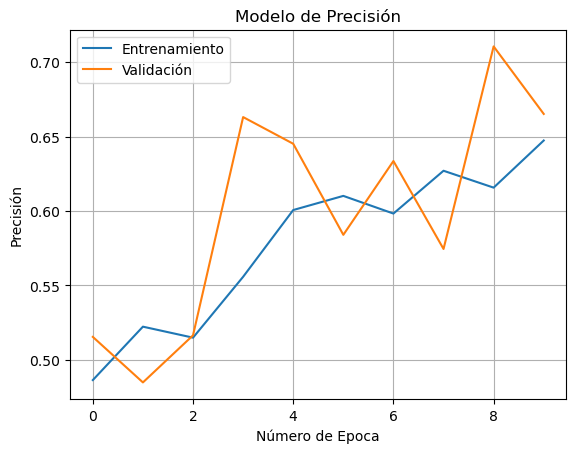

In [45]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Modelo de Precisión')
plt.ylabel('Precisión')
plt.xlabel('Número de Epoca')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.grid()
plt.show()

Carguemos el mejor modelo que haya alcanzado el mejor accuracy en el conjunto de validación para ver cómo se desempeña con data nunca vista

In [51]:
model.load_weights(OUTPUT_PATH)
score = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {round(100 * score[1], 2)}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6669 - loss: 3.4968
Precisión en el conjunto de prueba: 68.92


### **Redes Neuronales Convolucionales**
Efectivas para la clasificación de imágenes, ya que están diseñadas para reconocer patrones en los datos espaciales, como las imágenes.

#### **Creación yCompilación del modelo**
En este paso definimos el optimizador, es decir el método que se usará para actualizar los coeficientes de los filtros y de la Red Neuronal durante el entrenamiento.  
Añadimos la primera capa convolucional, con 6 filtros, cada uno de 5×5, sin padding y con stride igual a 1 y función de activación ReLU. Debemos igualmente definir de forma explícita el tamaño de cada imagen de entrada (128x128x1)

Ahora, añadimos la primera capa max-pooling. 

La segunda capa convolucional y la segunda de max-pooling se crean de la misma forma que las anteriores.

Aplanamos el volumen resultante usando Flatten().

In [83]:
# Convertir las etiquetas a formato binario 
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)


In [ ]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout # type: ignore

# Definir el número de clases
nclases = 2  # Número de clases, muffins y chihuahuas

# Definir el modelo
model = Sequential()

# Añadir capas convolucionales y de max pooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Añadir capa de regularización Dropout
model.add(Dropout(0.25))

# Añadir capa de aplanado
model.add(Flatten())

# Añadir capas de conexión completa y regularización Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Para clasificación binaria, usa 'sigmoid'

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [87]:
# Configuraciones de entrenamiento
BATCH_SIZE = 256
EPOCHS = 10

# Entrenar el modelo
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test, y_test)
)

# Evaluar el modelo
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 634s 27s/step - accuracy: 0.4863 - loss: -239.9522 - val_accuracy: 0.5405 - val_loss: -3972.3176
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - accuracy: 0.5387 - loss: -11907.2207 - val_accuracy: 0.5405 - val_loss: -71275.9219
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5485 - loss: -134416.1719 - val_accuracy: 0.5405 - val_loss: -480895.0938
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5431 - loss: -746129.0625 - val_accuracy: 0.5405 - val_loss: -1945718.2500
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5299 - loss: -2741564.7500 - val_accuracy: 0.5405 - val_loss: -5803599.5000
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5377 - loss: -7539687.0000 - val_accuracy: 0.5405 - val_loss: -14169984.0000
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5425 - loss: -17437318.0000 - val_accuracy: 0.5405 - val_loss: -30083104.0000
Epoch 8/10
19/19 ━━━━━━━━━━━

### **Análisis detallado del desempeño del modelo: la matriz de confusión**
La precisión que obtuvimos anteriormente es una medida global del desempeño de esta Red Convolucional, pero no nos permite ver si algunos dígitos son clasificados con mayor precisión que otros.

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


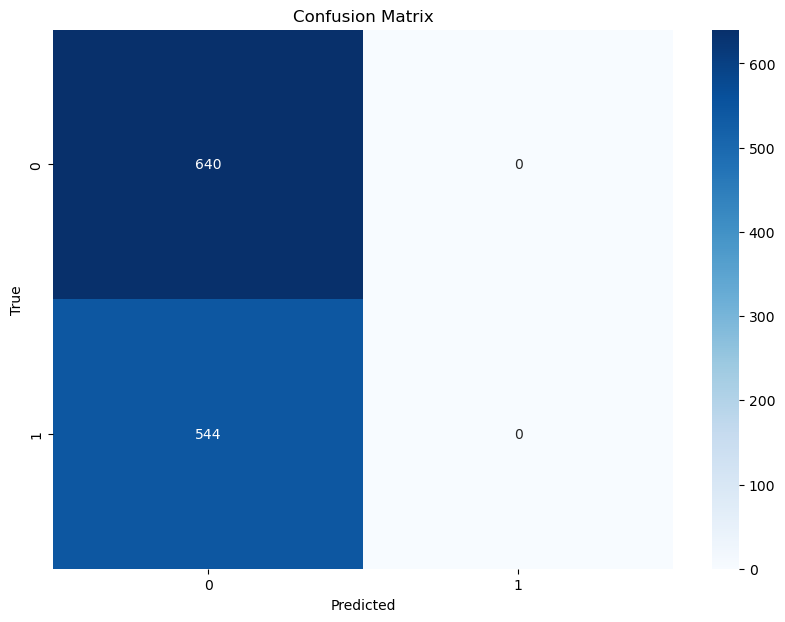

In [92]:
# Definir la función para graficar la matriz de confusión
def graficar_matriz_de_confusion(y_true, y_pred, etiquetas):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Hacer predicciones con el modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
y_ref = y_test
etiquetas = ['0', '1']  # Etiquetas para la clasificación binaria

# Graficar la matriz de confusión
graficar_matriz_de_confusion(y_ref, y_pred, etiquetas)


Carguemos el mejor modelo que haya alcanzado el mejor accuracy en el conjunto de validación para ver cómo se desempeña con data nunca vista

In [91]:
# Evaluar el modelo en el conjunto de prueba
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Precisión en el conjunto de prueba: {round(100 * score[1], 2)}')


Precisión en el conjunto de prueba: 54.05


### **Conclusión**
El perceptrón multicapa (MLP) con una precisión del 68,92%, está funcionando mejor que la red neuronal convolucional (CNN) con un 54,05%. Esto podría deberse a un exceso de complejidad en el CNN que no ha sido optimizada adecuadamente, o a que los datos no son lo suficientemente complejos o espaciales para que un CNN sea más efectivo que un MLP. Podría ser útil revisar la arquitectura del CNN, el tamaño del conjunto de entrenamiento, el preprocesamiento de datos y si se están aplicando técnicas adecuadas de regularización o aumento de datos para mejorar el rendimiento del CNN.
Las mejores recomendaciones para mejorar la precisión del CNN:
-	El aumento de los datos para incrementar la cantidad y diversidad de los datos de entrenamiento.
-	Ajustar los hiperparámetros, como el tamaño del lote y el número de épocas. 
-	Mejorar la arquitectura del modelo.
-	Regularización.
